<a href="https://colab.research.google.com/github/shoreey/AI-Model-for-detection-of-Inflammation-in-bowel/blob/main/AI_model_to_predict_the_classes_of_inflammation_in_bowel_disease_using_endoscopic_video_and_images_and_histology_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification to predict classes from endoscopy Data

# Imporitng Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import io
import pandas as pd
import random
import scipy.io as sio
from scipy import ndimage
import scipy
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from scipy.io import loadmat
import torch
import torch.nn as nn
import math
from functools import partial
from torch.autograd import Variable

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time
import datetime
import copy

from PIL import Image

# Importing the Libraries

In [ ]:
BASE_DIR="D:\Data"
data_df = pd.read_excel("D:\PicassoOnly_AI_corretti_rev.xlsx")
data_df["Class"]=data_df["Score"]>3 # Use PICaSSO score for classifying as healing/inflamed

data_df.head()
#print (len(data_df))

,Num,Video,Filename,Filename_WL_UCEIS,Mucosal,Vascular,Score,MES>1,UCEIS>1,RHI>3,...,VCE Frame 7,VCE Frame 8,VCE Frame 9,VCE Frame 10,VCE Frame 11,VCE Frame 12,VCE Frame 13,VCE Frame 14,VCE Frame 15,Class
0,1,01-01 rectum,muc_229_pat0101_section1.mat,muc_001_pat0101_section1.mat,7.0,3.0,13,3.0,5,8.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,True
1,2,01-01 sigmoid,muc_230_pat0101_section2.mat,none,0.0,0.0,0,0.0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,3,01-02 rectum,muc_001_pat0102_section1.mat,muc_002_pat0102_section1.mat,0.0,0.0,0,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,4,01-02 sigmoid,muc_002_pat0102_section2.mat,muc_003_pat0102_section2.mat,0.0,0.0,0,0.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,5,01-03 rectum,muc_003_pat0103_section1.mat,muc_004_pat0103_section1.mat,0.0,0.0,0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


# Checking the Loading of the Frames

Frames shape: (320, 412, 3, 15)
Number of frames: 15


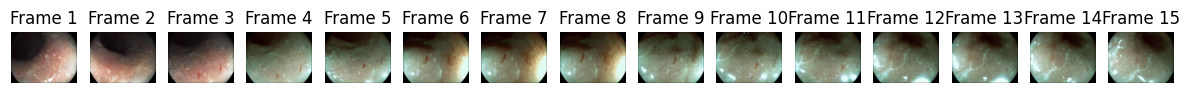

dict_keys(['__header__', '__version__', '__globals__', 'x'])


In [ ]:
# Function to load frames from mat files
def load_frames_from_mat(data_df):
    mat_file_path = os.path.join(BASE_DIR, data_df)

    # Load the variable 'x' from the mat file
    mat_data = loadmat(mat_file_path)
    frames = mat_data['x']

    return mat_data, frames

# Test loading frames from the first row of the dataset
mat_data, sample_frames = load_frames_from_mat(data_df['Filename'].iloc[0])

# Display information about the loaded frames
print(f"Frames shape: {sample_frames.shape}")
print(f"Number of frames: {sample_frames.shape[-1]}")

# Display all frames using matplotlib
num_frames = sample_frames.shape[-1]

plt.figure(figsize=(15, 5))
for i in range(num_frames):
    plt.subplot(1, num_frames, i + 1)
    plt.imshow(sample_frames[:, :, :, i])
    plt.axis('off')
    plt.title(f"Frame {i + 1}")

plt.show()

# Print keys of the loaded data
print(mat_data.keys())


# Data Visualization

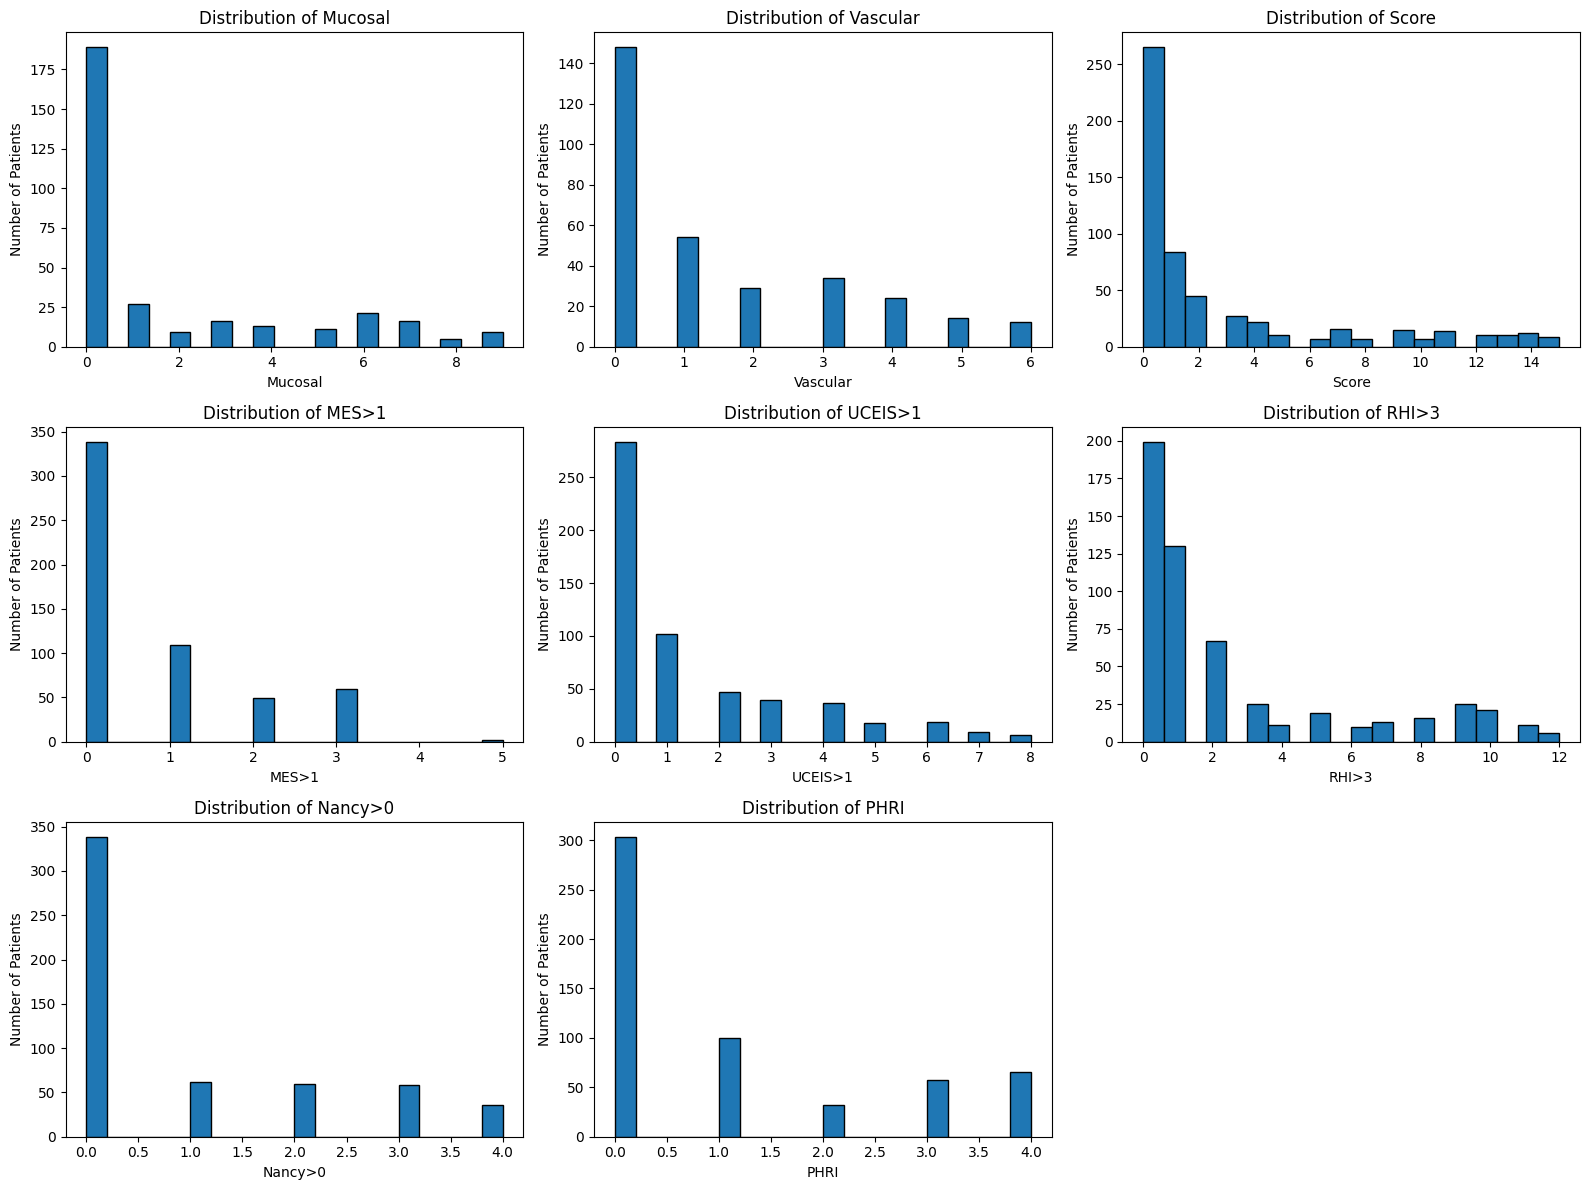

In [ ]:
# Extract relevant columns
columns_of_interest = ['Mucosal', 'Vascular', 'Score', 'MES>1', 'UCEIS>1', 'RHI>3', 'Nancy>0', 'PHRI']

# Plot histograms for each column
plt.figure(figsize=(16, 12))

for i, column in enumerate(columns_of_interest, 1):
    plt.subplot(3, 3, i)
    plt.hist(data_df[column], bins=20, edgecolor='black')  # You can adjust the number of bins as needed
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Number of Patients')

plt.tight_layout()
plt.show()


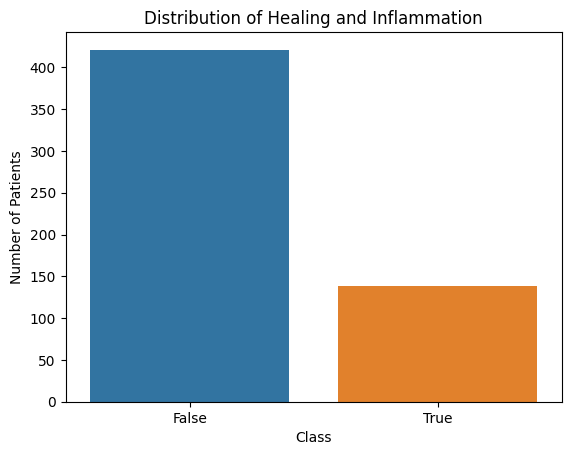

Class Distribution:
Class
False    421
True     139
Name: count, dtype: int64


In [ ]:
import seaborn as sns

# Assuming the column indicating healing or inflammation is named 'Class'
# Adjust the column name accordingly if it's different
sns.countplot(x='Class', data=data_df)
plt.title('Distribution of Healing and Inflammation')
plt.xlabel('Class')
plt.ylabel('Number of Patients')
plt.show()

# Assuming the column indicating healing or inflammation is named 'Class'
# Adjust the column name accordingly if it's different
class_distribution = data_df['Class'].value_counts()
print("Class Distribution:")
print(class_distribution)




In [ ]:
import pandas as pd

# Assuming 'data_df' is your DataFrame containing the columns 'Train_VCE_Endo' and 'Train_WL_Endo'

# Print distribution counts for each column
for column in data_df.columns:
    print(f"Column: {column}")
    print(data_df[column].value_counts())
    print()


Column: Num
Num
1      3
59     3
69     3
68     3
67     3
      ..
208    1
209    1
210    1
211    1
0      1
Name: count, Length: 317, dtype: int64

Column: Video
Video
12-22 rectum     2
09-10 Sigmoi     1
09-03 Sigmoi     1
09-07 Rectum     1
09-07 Sigmoi     1
                ..
03-13 sigmoid    1
03-13 rectum     1
03-12 sigmoid    1
03-12 rectum     1
13-05 rectum     1
Name: count, Length: 559, dtype: int64

Column: Filename
Filename
none                            8
muc_229_pat0101_section1.mat    1
09-03 Sigmoid iscan_2_3.mat     1
09-07 Sigmoid iscan_2_3.mat     1
09-09 Rectum iscan_2_3.mat      1
                               ..
muc_179_pat0316_section2.mat    1
muc_178_pat0315_section2.mat    1
muc_177_pat0314_section2.mat    1
muc_176_pat0314_section1.mat    1
13-05 rectum VCE.mat            1
Name: count, Length: 553, dtype: int64

Column: Filename_WL_UCEIS
Filename_WL_UCEIS
none                            16
muc_208_pat0415_section2.mat     1
muc_206_pat0414_sectio

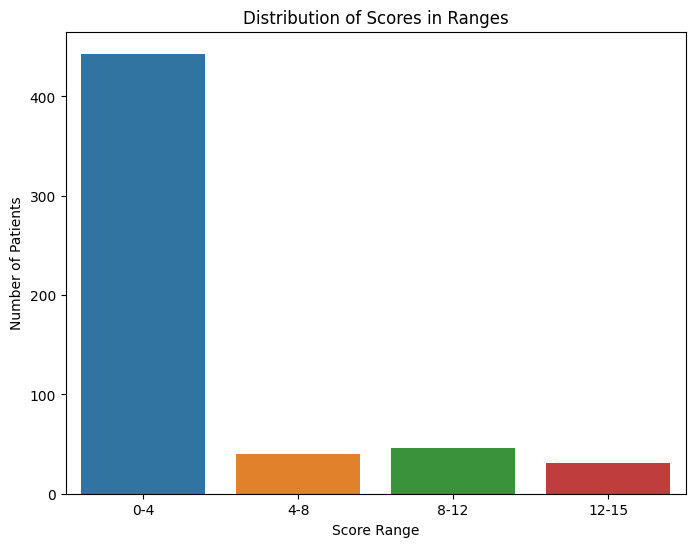

Score Range Distribution:
Score_Range
0-4      443
8-12      46
4-8       40
12-15     31
Name: count, dtype: int64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom bins for the 'Score' ranges
bins = [0, 4, 8, 12, 15]

# Create a new column 'Score_Range' to categorize scores into the specified bins
data_df['Score_Range'] = pd.cut(data_df['Score'], bins=bins, include_lowest=True, labels=['0-4', '4-8', '8-12', '12-15'])

# Plotting the distribution of 'Score' in specified ranges
plt.figure(figsize=(8, 6))
sns.countplot(x='Score_Range', data=data_df, order=['0-4', '4-8', '8-12', '12-15'])
plt.title('Distribution of Scores in Ranges')
plt.xlabel('Score Range')
plt.ylabel('Number of Patients')
plt.show()

# Print the count of patients in each score range
print("Score Range Distribution:")
print(data_df['Score_Range'].value_counts())



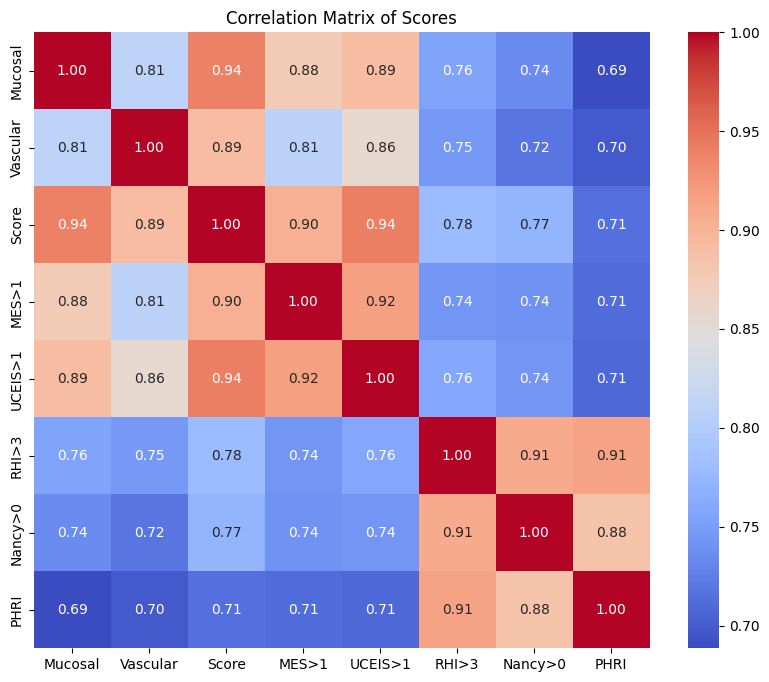

Correlation Matrix:
           Mucosal  Vascular     Score     MES>1   UCEIS>1     RHI>3  \
Mucosal   1.000000  0.809348  0.939959  0.875137  0.891043  0.756544   
Vascular  0.809348  1.000000  0.891784  0.808173  0.855307  0.745920   
Score     0.939959  0.891784  1.000000  0.903711  0.940450  0.779535   
MES>1     0.875137  0.808173  0.903711  1.000000  0.916852  0.743798   
UCEIS>1   0.891043  0.855307  0.940450  0.916852  1.000000  0.758785   
RHI>3     0.756544  0.745920  0.779535  0.743798  0.758785  1.000000   
Nancy>0   0.735131  0.718437  0.771592  0.740888  0.743854  0.908217   
PHRI      0.688514  0.699305  0.714439  0.711831  0.708105  0.914332   

           Nancy>0      PHRI  
Mucosal   0.735131  0.688514  
Vascular  0.718437  0.699305  
Score     0.771592  0.714439  
MES>1     0.740888  0.711831  
UCEIS>1   0.743854  0.708105  
RHI>3     0.908217  0.914332  
Nancy>0   1.000000  0.884882  
PHRI      0.884882  1.000000  


In [ ]:
# Extract columns related to scores
score_columns = ['Mucosal', 'Vascular', 'Score', 'MES>1', 'UCEIS>1', 'RHI>3', 'Nancy>0', 'PHRI']

# Create a correlation matrix
correlation_matrix = data_df[score_columns].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Scores')
plt.show()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)


# Building the Dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import scipy.io as sio

class IBD_Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms=None):
        self.df = df
        self.imfolder = imfolder
        self.train = train
        self.transforms = transforms

    def __getitem__(self, index):
        filename = self.df.iloc[index]['Filename']
        im_path = os.path.join(self.imfolder, filename.strip())
        data = sio.loadmat(im_path)
        img = data['x']

        img_mean = img.mean(axis=0).mean(axis=0)
        img_mean = img_mean[0, :].squeeze()
        img = img[:, :, :, img_mean > 20]

        sx = img.shape
        numframe = sx[3]

        if self.train:
            x = torch.zeros(numframe, 224, 224, 3)
            img = img[:, 0:400, :, :]
            img = torch.from_numpy(img)
            img = img.permute((3, 0, 1, 2))
            for i in range(numframe):
                tmp = img[i, :, :, :].squeeze()
                tmp = torch.tensor(tmp)
                tmp = tmp.type(torch.FloatTensor)
                tmp = tmp.permute(2, 0, 1)
                tmp = self.transforms(tmp)
                tmp = tmp.permute(1, 2, 0)
                x[i, :, :, :] = tmp

            # Aggregate frame scores
            frame_scores = []
            for i in range(numframe):
                frame_col = 'VCE Frame ' + str(i + 1)
                frame_score = self.df.iloc[index][frame_col]
                frame_scores.append(frame_score)

            # Calculate the aggregated score (e.g., sum, mean, or max)
            aggregated_score = sum(frame_scores)

            y = self.df.iloc[index]['Class']
            w = self.df.iloc[index]['Score']
            return x, aggregated_score, w, frame_scores
        else:
            x = torch.zeros(numframe, 224, 224, 3)
            img = img[:, 0:400, :, :]
            img = torch.from_numpy(img)
            img = img.permute((3, 0, 1, 2))
            for i in range(numframe):
                tmp = img[i, :, :, :].squeeze()
                tmp = torch.tensor(tmp)
                tmp = tmp.type(torch.FloatTensor)
                tmp = tmp.permute(2, 0, 1)
                tmp = self.transforms(tmp)
                tmp = tmp.permute(1, 2, 0)
                x[i, :, :, :] = tmp

            return x

    def __len__(self):
        return len(self.df)


# Extract all data belonging to the training set
train = data_df[data_df['Train_VCE_Endo'] == 1]

# Extract all data belonging to the validation set
valid = data_df[data_df['Train_VCE_Endo'] == 0]

# Reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# Targets for training and validation
train_targets = train.Class.values
valid_targets = valid.Class.values

# Transformation pipelines
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(45, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create instances of the IBD_Dataset class
train_dataset = IBD_Dataset(df=train, imfolder=BASE_DIR, train=True, transforms=train_transforms)
valid_dataset = IBD_Dataset(df=valid, imfolder=BASE_DIR, train=True, transforms=valid_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=15, shuffle=False)


# Building the Model

# Densenet

tensor([0.4497, 1.0000])
[169  76]


C:\Users\shaur\anaconda3\envs\new\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shaur\anaconda3\envs\new\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 17/17 [01:50<00:00,  6.50s/it]


Training Loss (Epoch 1/10): 0.8257
Training Accuracy (Epoch 1/10): 63.67%


Validation (Epoch 1/10: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Validation Loss (Epoch 1/10): 2.1015
Validation Accuracy (Epoch 1/10): 46.77%


Epoch 2/10: 100%|██████████| 17/17 [01:51<00:00,  6.55s/it]


Training Loss (Epoch 2/10): 0.5675
Training Accuracy (Epoch 2/10): 69.39%


Validation (Epoch 2/10: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Validation Loss (Epoch 2/10): 1.2612
Validation Accuracy (Epoch 2/10): 58.06%


Epoch 3/10: 100%|██████████| 17/17 [01:51<00:00,  6.57s/it]


Training Loss (Epoch 3/10): 0.5300
Training Accuracy (Epoch 3/10): 75.51%


Validation (Epoch 3/10: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Validation Loss (Epoch 3/10): 0.8490
Validation Accuracy (Epoch 3/10): 64.52%


Epoch 4/10: 100%|██████████| 17/17 [01:51<00:00,  6.55s/it]


Training Loss (Epoch 4/10): 0.4874
Training Accuracy (Epoch 4/10): 78.78%


Validation (Epoch 4/10: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Validation Loss (Epoch 4/10): 0.8129
Validation Accuracy (Epoch 4/10): 62.90%


Epoch 5/10: 100%|██████████| 17/17 [01:51<00:00,  6.54s/it]


Training Loss (Epoch 5/10): 0.5737
Training Accuracy (Epoch 5/10): 76.73%


Validation (Epoch 5/10: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Validation Loss (Epoch 5/10): 1.0021
Validation Accuracy (Epoch 5/10): 79.03%


Epoch 6/10: 100%|██████████| 17/17 [01:50<00:00,  6.53s/it]


Training Loss (Epoch 6/10): 0.4807
Training Accuracy (Epoch 6/10): 80.82%


Validation (Epoch 6/10: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Validation Loss (Epoch 6/10): 1.0741
Validation Accuracy (Epoch 6/10): 61.29%


Epoch 7/10: 100%|██████████| 17/17 [01:51<00:00,  6.54s/it]


Training Loss (Epoch 7/10): 0.5909
Training Accuracy (Epoch 7/10): 69.39%


Validation (Epoch 7/10: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Validation Loss (Epoch 7/10): 0.6232
Validation Accuracy (Epoch 7/10): 83.87%


Epoch 8/10: 100%|██████████| 17/17 [01:51<00:00,  6.53s/it]


Training Loss (Epoch 8/10): 0.5764
Training Accuracy (Epoch 8/10): 75.92%


Validation (Epoch 8/10: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Validation Loss (Epoch 8/10): 4.3006
Validation Accuracy (Epoch 8/10): 37.10%


Epoch 9/10: 100%|██████████| 17/17 [01:51<00:00,  6.56s/it]


Training Loss (Epoch 9/10): 0.4758
Training Accuracy (Epoch 9/10): 77.55%


Validation (Epoch 9/10: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Validation Loss (Epoch 9/10): 0.5177
Validation Accuracy (Epoch 9/10): 75.81%


Epoch 10/10: 100%|██████████| 17/17 [01:50<00:00,  6.53s/it]


Training Loss (Epoch 10/10): 0.4437
Training Accuracy (Epoch 10/10): 80.41%


Validation (Epoch 10/10: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

Validation Loss (Epoch 10/10): 0.6631
Validation Accuracy (Epoch 10/10): 70.97%
Best Training Accuracy: 80.82%
Best Validation Accuracy: 83.87%


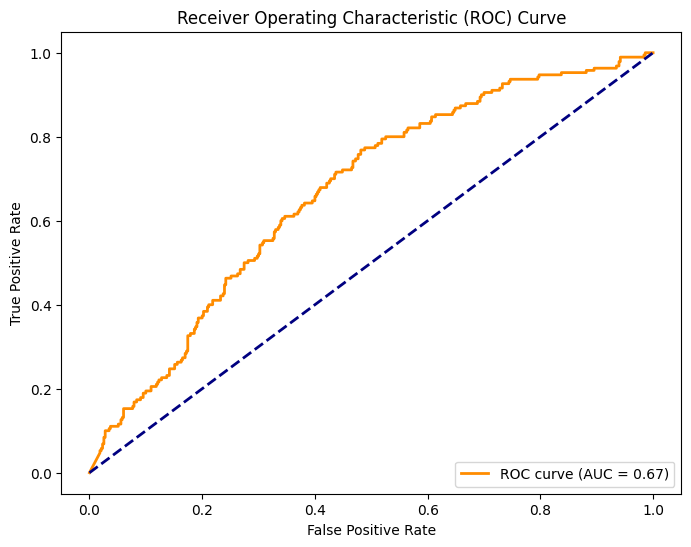

Confusion Matrix
[[283 147]
 [ 76 114]]
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.79      0.66      0.72       430
     Class 1       0.44      0.60      0.51       190

    accuracy                           0.64       620
   macro avg       0.61      0.63      0.61       620
weighted avg       0.68      0.64      0.65       620



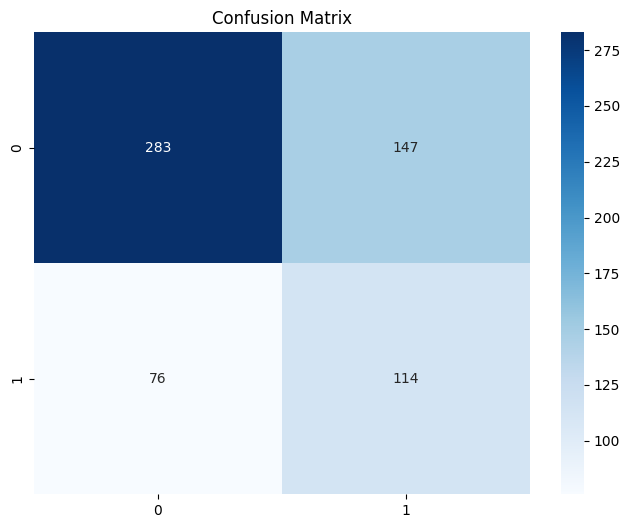

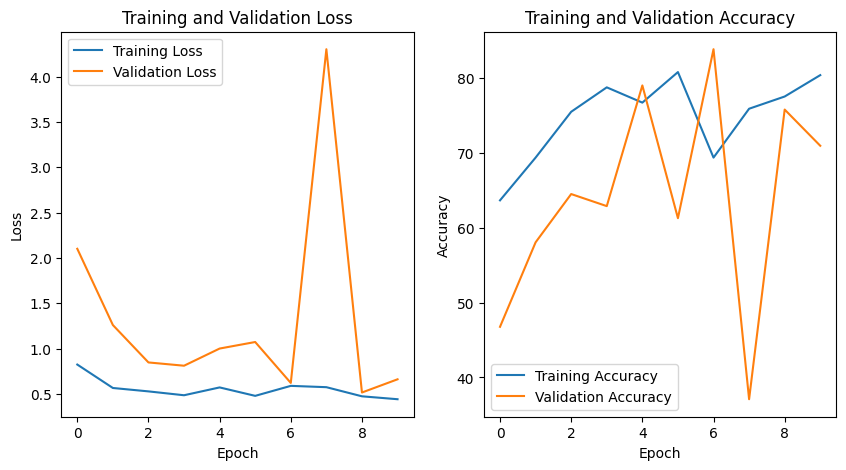

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import densenet161
from PIL import Image
import pandas as pd
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate class weights
class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
class_weight = torch.from_numpy(weight)
class_weight = class_weight / class_weight.max()
class_weight = class_weight.type(torch.FloatTensor)
print(class_weight)
print(class_sample_count)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=15, shuffle=False)

# Set the device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define a new model class that utilizes DenseNet-161 as the backbone
class DenseNet161WithAttention(nn.Module):
    def __init__(self):
        super(DenseNet161WithAttention, self).__init__()
        # Load the pretrained DenseNet-161 model
        densenet = densenet161(pretrained=True)
        # Remove the classification layer
        self.features = densenet.features
        self.classifier = nn.Sequential(
            nn.Linear(densenet.classifier.in_features, 2)  # Assuming binary classification
        )
        # Attention mechanism
        self.attention = nn.Linear(densenet.classifier.in_features, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Extract features using DenseNet-161 backbone
        features = self.features(x)
        features = features.mean(dim=[2, 3])  # Global average pooling
        # Apply attention mechanism
        att_weights = self.softmax(self.attention(features))
        features = torch.mul(features, att_weights)
        # Classify features
        x = self.classifier(features)
        return x, att_weights

# Create an instance of DenseNet161WithAttention and move it to the device
model = DenseNet161WithAttention().to(device)

# Assuming you have defined the train_loader and valid_loader

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics for plotting
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
all_labels_roc = []
all_probs_roc = []
all_preds = []

# Number of training epochs
num_epochs = 10

# Variables for early stopping
early_stopping_counter = 0
early_stopping_threshold = 5  # Adjust this threshold as needed
best_train_accuracy = 0.0
best_valid_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels, _, posframe in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        # Move inputs, labels, and posframe to the device
        inputs, labels, posframe = inputs.to(device), labels.to(device), posframe.to(device)

        optimizer.zero_grad()

        # Assuming your model returns a tuple and you want to use the first element
        outputs = model(inputs)[0]

        # Convert labels to the correct data type (torch.long)
        labels = labels.type(torch.long)

        # Use posframe for something during training if needed

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    accuracy_train = 100 * correct_train / total_train
    train_accuracies.append(accuracy_train)

    print(f'Training Loss (Epoch {epoch + 1}/{num_epochs}): {average_loss:.4f}')
    print(f'Training Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_train:.2f}%')

    # Validation
    model.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    # Inside the validation loop
    with torch.no_grad():
        for inputs, labels, _, _ in tqdm(valid_loader, desc=f'Validation (Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert labels to the correct data type (torch.long)
            labels = labels.type(torch.long)

            outputs = model(inputs)[0]
            valid_loss = criterion(outputs, labels)
            total_valid_loss += valid_loss.item()

            _, predicted = outputs.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted.eq(labels).sum().item()

            # Append labels, predicted probabilities, and predictions for ROC curve and confusion matrix
            all_labels_roc.extend(labels.cpu().numpy())
            all_probs_roc.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    average_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(average_valid_loss)

    accuracy_valid = 100 * correct_valid / total_valid
    valid_accuracies.append(accuracy_valid)

    print(f'Validation Loss (Epoch {epoch + 1}/{num_epochs}): {average_valid_loss:.4f}')
    print(f'Validation Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_valid:.2f}%')

    # Early stopping check
    if accuracy_train > best_train_accuracy:
        best_train_accuracy = accuracy_train

    if accuracy_valid > best_valid_accuracy:
        best_valid_accuracy = accuracy_valid
        early_stopping_counter = 0
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_threshold:
        print(f'Early stopping triggered at epoch {epoch + 1}. Best validation accuracy: {best_valid_accuracy:.2f}% at epoch {best_epoch}')
        break

# Print the best training and validation accuracy
print(f'Best Training Accuracy: {best_train_accuracy:.2f}%')
print(f'Best Validation Accuracy: {best_valid_accuracy:.2f}%')


# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels_roc, all_probs_roc)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix (at the end)
cm = confusion_matrix(all_labels_roc, all_preds)
print('Confusion Matrix')
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels_roc), yticklabels=np.unique(all_preds))
plt.title('Confusion Matrix')

# Classification Report (at the end)
report = classification_report(all_labels_roc, all_preds, target_names=['Class 0', 'Class 1'], zero_division=1)
print('Classification Report:\n', report)

# Plotting
plt.figure(figsize=(10, 5))

# Plotting Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Resnet50

C:\Users\shaur\anaconda3\envs\new\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shaur\anaconda3\envs\new\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 17/17 [00:36<00:00,  2.15s/it]


Training Loss (Epoch 1/10): 0.9599
Training Accuracy (Epoch 1/10): 66.12%


Validation (Epoch 1/10: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Validation Loss (Epoch 1/10): 4.1315
Validation Accuracy (Epoch 1/10): 35.48%


Epoch 2/10: 100%|██████████| 17/17 [00:37<00:00,  2.20s/it]


Training Loss (Epoch 2/10): 0.6362
Training Accuracy (Epoch 2/10): 67.35%


Validation (Epoch 2/10: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Loss (Epoch 2/10): 0.8183
Validation Accuracy (Epoch 2/10): 69.35%


Epoch 3/10: 100%|██████████| 17/17 [00:37<00:00,  2.20s/it]


Training Loss (Epoch 3/10): 0.6064
Training Accuracy (Epoch 3/10): 67.35%


Validation (Epoch 3/10: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Validation Loss (Epoch 3/10): 0.7195
Validation Accuracy (Epoch 3/10): 69.35%


Epoch 4/10: 100%|██████████| 17/17 [00:37<00:00,  2.19s/it]


Training Loss (Epoch 4/10): 0.5911
Training Accuracy (Epoch 4/10): 68.98%


Validation (Epoch 4/10: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Validation Loss (Epoch 4/10): 0.6835
Validation Accuracy (Epoch 4/10): 69.35%


Epoch 5/10: 100%|██████████| 17/17 [00:37<00:00,  2.19s/it]


Training Loss (Epoch 5/10): 0.5379
Training Accuracy (Epoch 5/10): 74.69%


Validation (Epoch 5/10: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Validation Loss (Epoch 5/10): 0.7287
Validation Accuracy (Epoch 5/10): 64.52%


Epoch 6/10: 100%|██████████| 17/17 [00:37<00:00,  2.21s/it]


Training Loss (Epoch 6/10): 0.6072
Training Accuracy (Epoch 6/10): 72.65%


Validation (Epoch 6/10: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Validation Loss (Epoch 6/10): 22.9765
Validation Accuracy (Epoch 6/10): 64.52%


Epoch 7/10: 100%|██████████| 17/17 [00:37<00:00,  2.20s/it]


Training Loss (Epoch 7/10): 0.6270
Training Accuracy (Epoch 7/10): 68.98%


Validation (Epoch 7/10: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Validation Loss (Epoch 7/10): 0.7211
Validation Accuracy (Epoch 7/10): 62.90%
Early stopping triggered at epoch 7. Best validation accuracy: 69.35% at epoch 2
Best Training Accuracy: 74.69%
Best Validation Accuracy: 69.35%


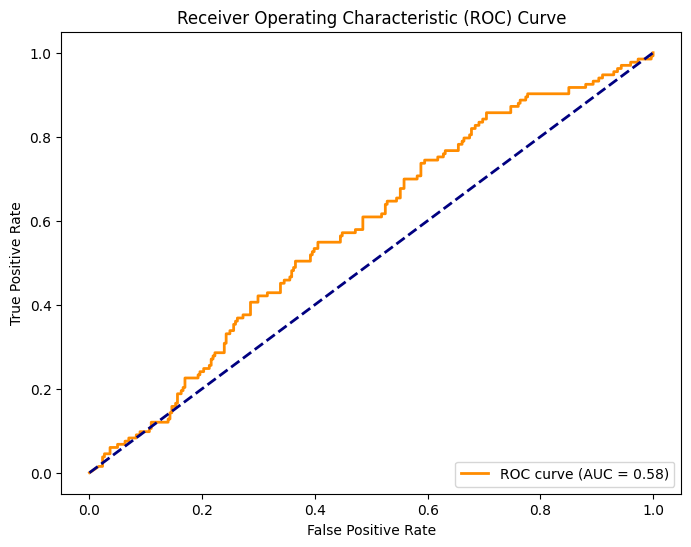

Confusion Matrix
[[223  78]
 [ 86  47]]
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.72      0.74      0.73       301
     Class 1       0.38      0.35      0.36       133

    accuracy                           0.62       434
   macro avg       0.55      0.55      0.55       434
weighted avg       0.62      0.62      0.62       434



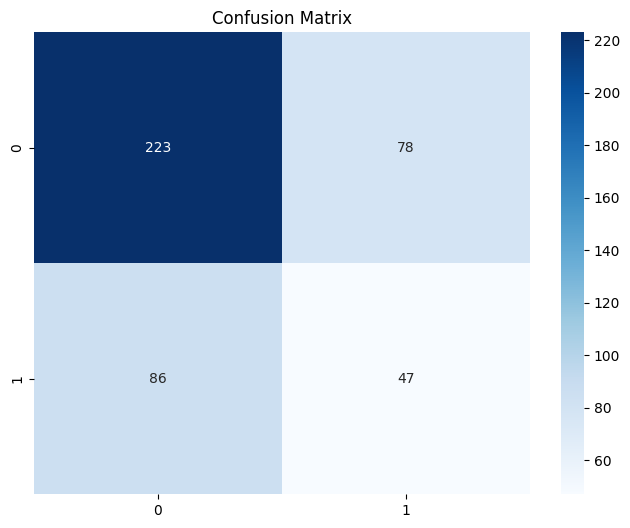

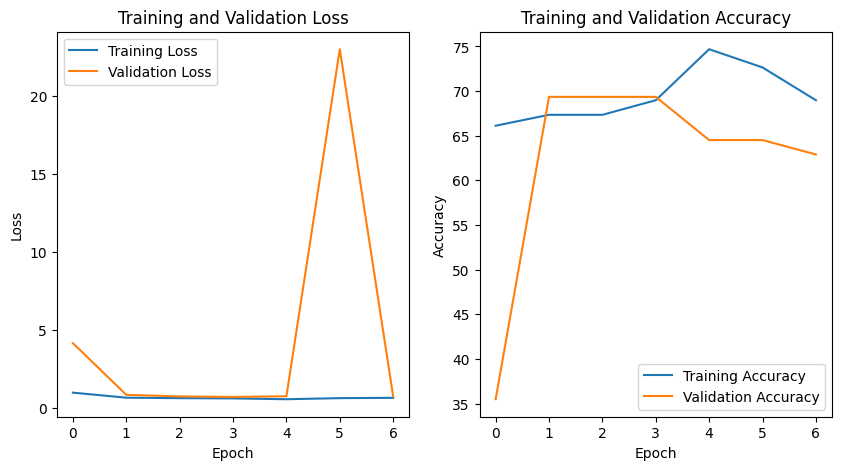

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from PIL import Image
import pandas as pd
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_dataset and valid_dataset are defined

# Calculate class weights
class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
class_weight = torch.from_numpy(weight)
class_weight = class_weight / class_weight.max()
class_weight = class_weight.type(torch.FloatTensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=15, shuffle=False)

# Set the device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define a new model class that utilizes ResNet-50 as the backbone
class ResNet50WithAttention(nn.Module):
    def __init__(self):
        super(ResNet50WithAttention, self).__init__()
        # Load the pretrained ResNet-50 model
        resnet = resnet50(pretrained=True)
        # Remove the classification layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Linear(resnet.fc.in_features, 2)  # Assuming binary classification
        # Attention mechanism
        self.attention = nn.Linear(resnet.fc.in_features, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Extract features using ResNet-50 backbone
        features = self.features(x)
        features = features.view(features.size(0), -1)
        # Apply attention mechanism
        att_weights = self.softmax(self.attention(features))
        features = torch.mul(features, att_weights)
        # Classify features
        x = self.classifier(features)
        return x, att_weights

# Create an instance of ResNet50WithAttention and move it to the device
model = ResNet50WithAttention().to(device)

# Assuming you have defined the train_loader and valid_loader

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics for plotting
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
all_labels_roc = []
all_probs_roc = []
all_preds = []

# Number of training epochs
num_epochs = 10

# Variables for early stopping
early_stopping_counter = 0
early_stopping_threshold = 5  # Adjust this threshold as needed
best_train_accuracy = 0.0
best_valid_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels, _, posframe in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        # Move inputs, labels, and posframe to the device
        inputs, labels, posframe = inputs.to(device), labels.to(device), posframe.to(device)

        optimizer.zero_grad()

        # Assuming your model returns a tuple and you want to use the first element
        outputs = model(inputs)[0]

        # Convert labels to the correct data type (torch.long)
        labels = labels.type(torch.long)

        # Use posframe for something during training if needed

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    accuracy_train = 100 * correct_train / total_train
    train_accuracies.append(accuracy_train)

    print(f'Training Loss (Epoch {epoch + 1}/{num_epochs}): {average_loss:.4f}')
    print(f'Training Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_train:.2f}%')

    # Validation
    model.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    # Inside the validation loop
    with torch.no_grad():
        for inputs, labels, _, _ in tqdm(valid_loader, desc=f'Validation (Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert labels to the correct data type (torch.long)
            labels = labels.type(torch.long)

            outputs = model(inputs)[0]
            valid_loss = criterion(outputs, labels)
            total_valid_loss += valid_loss.item()

            _, predicted = outputs.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted.eq(labels).sum().item()

            # Append labels, predicted probabilities, and predictions for ROC curve and confusion matrix
            all_labels_roc.extend(labels.cpu().numpy())
            all_probs_roc.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    average_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(average_valid_loss)

    accuracy_valid = 100 * correct_valid / total_valid
    valid_accuracies.append(accuracy_valid)

    print(f'Validation Loss (Epoch {epoch + 1}/{num_epochs}): {average_valid_loss:.4f}')
    print(f'Validation Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_valid:.2f}%')

    # Early stopping check
    if accuracy_train > best_train_accuracy:
        best_train_accuracy = accuracy_train

    if accuracy_valid > best_valid_accuracy:
        best_valid_accuracy = accuracy_valid
        early_stopping_counter = 0
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_threshold:
        print(f'Early stopping triggered at epoch {epoch + 1}. Best validation accuracy: {best_valid_accuracy:.2f}% at epoch {best_epoch}')
        break

# Print the best training and validation accuracy
print(f'Best Training Accuracy: {best_train_accuracy:.2f}%')
print(f'Best Validation Accuracy: {best_valid_accuracy:.2f}%')


# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels_roc, all_probs_roc)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix (at the end)
cm = confusion_matrix(all_labels_roc, all_preds)
print('Confusion Matrix')
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels_roc), yticklabels=np.unique(all_preds))
plt.title('Confusion Matrix')

# Classification Report (at the end)
report = classification_report(all_labels_roc, all_preds, target_names=['Class 0', 'Class 1'], zero_division=1)
print('Classification Report:\n', report)

# Plotting
plt.figure(figsize=(10, 5))

# Plotting Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# EfficientNet

Loaded pretrained weights for efficientnet-b7


Epoch 1/10: 100%|██████████| 17/17 [02:56<00:00, 10.36s/it]


Training Loss (Epoch 1/10): 0.6515
Training Accuracy (Epoch 1/10): 64.90%


Validation (Epoch 1/10: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


Validation Loss (Epoch 1/10): 0.6180
Validation Accuracy (Epoch 1/10): 75.81%


Epoch 2/10: 100%|██████████| 17/17 [02:50<00:00, 10.01s/it]


Training Loss (Epoch 2/10): 0.5307
Training Accuracy (Epoch 2/10): 75.10%


Validation (Epoch 2/10: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


Validation Loss (Epoch 2/10): 1.2171
Validation Accuracy (Epoch 2/10): 79.03%


Epoch 3/10: 100%|██████████| 17/17 [02:49<00:00,  9.95s/it]


Training Loss (Epoch 3/10): 0.4319
Training Accuracy (Epoch 3/10): 82.86%


Validation (Epoch 3/10: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


Validation Loss (Epoch 3/10): 1.1101
Validation Accuracy (Epoch 3/10): 83.87%


Epoch 4/10: 100%|██████████| 17/17 [02:48<00:00,  9.94s/it]


Training Loss (Epoch 4/10): 0.4351
Training Accuracy (Epoch 4/10): 80.00%


Validation (Epoch 4/10: 100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


Validation Loss (Epoch 4/10): 2.4072
Validation Accuracy (Epoch 4/10): 88.71%


Epoch 5/10: 100%|██████████| 17/17 [02:49<00:00,  9.97s/it]


Training Loss (Epoch 5/10): 0.4014
Training Accuracy (Epoch 5/10): 84.49%


Validation (Epoch 5/10: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


Validation Loss (Epoch 5/10): 1.9468
Validation Accuracy (Epoch 5/10): 75.81%


Epoch 6/10: 100%|██████████| 17/17 [02:49<00:00,  9.95s/it]


Training Loss (Epoch 6/10): 0.3881
Training Accuracy (Epoch 6/10): 81.63%


Validation (Epoch 6/10: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Validation Loss (Epoch 6/10): 2.5897
Validation Accuracy (Epoch 6/10): 75.81%


Epoch 7/10: 100%|██████████| 17/17 [02:49<00:00,  9.94s/it]


Training Loss (Epoch 7/10): 0.4798
Training Accuracy (Epoch 7/10): 82.04%


Validation (Epoch 7/10: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


Validation Loss (Epoch 7/10): 5.5581
Validation Accuracy (Epoch 7/10): 72.58%


Epoch 8/10: 100%|██████████| 17/17 [02:50<00:00, 10.00s/it]


Training Loss (Epoch 8/10): 0.5019
Training Accuracy (Epoch 8/10): 80.82%


Validation (Epoch 8/10: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


Validation Loss (Epoch 8/10): 0.6782
Validation Accuracy (Epoch 8/10): 69.35%


Epoch 9/10: 100%|██████████| 17/17 [02:48<00:00,  9.91s/it]


Training Loss (Epoch 9/10): 0.5166
Training Accuracy (Epoch 9/10): 79.18%


Validation (Epoch 9/10: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]

Validation Loss (Epoch 9/10): 0.5358
Validation Accuracy (Epoch 9/10): 66.13%
Early stopping triggered at epoch 9. Best validation accuracy: 88.71% at epoch 4
Best Training Accuracy: 84.49%
Best Validation Accuracy: 88.71%


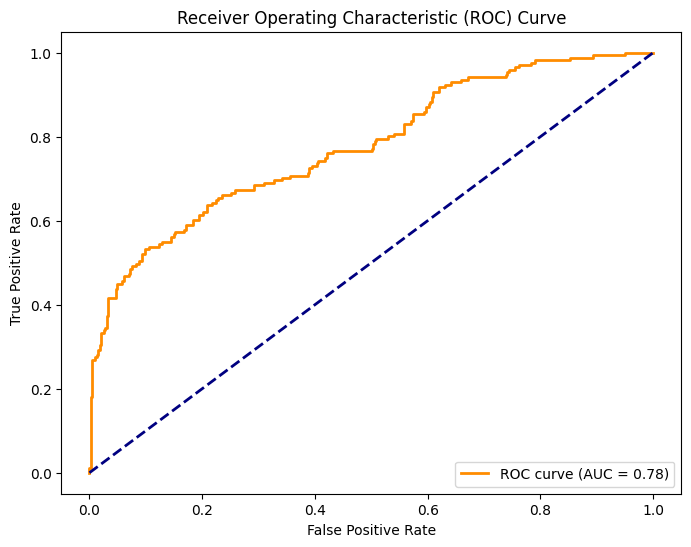

Confusion Matrix
[[332  55]
 [ 77  94]]
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.81      0.86      0.83       387
     Class 1       0.63      0.55      0.59       171

    accuracy                           0.76       558
   macro avg       0.72      0.70      0.71       558
weighted avg       0.76      0.76      0.76       558



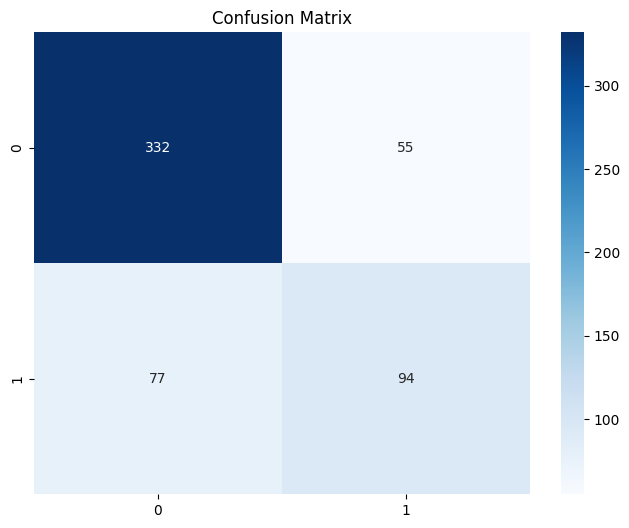

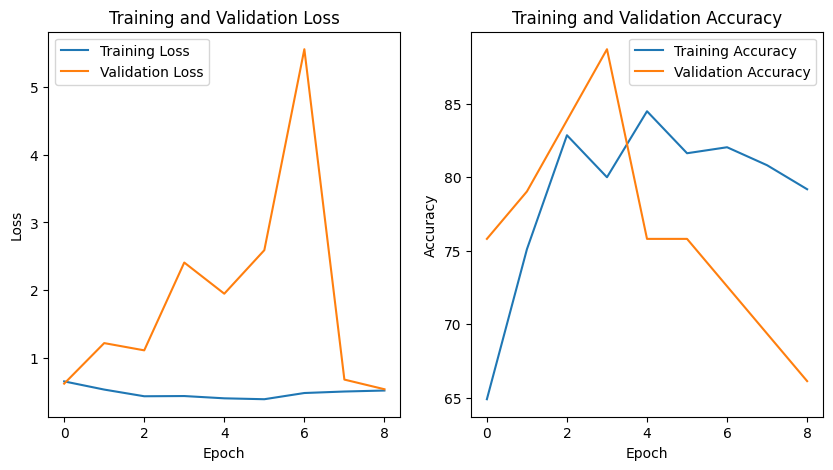

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import pandas as pd
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_dataset and valid_dataset are defined

# Calculate class weights
class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
class_weight = torch.from_numpy(weight)
class_weight = class_weight / class_weight.max()
class_weight = class_weight.type(torch.FloatTensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=15, shuffle=False)

# Set the device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define a new model class that utilizes EfficientNet-B7 as the backbone
class EfficientNetB7WithAttention(nn.Module):
    def __init__(self):
        super(EfficientNetB7WithAttention, self).__init__()
        # Load the pretrained EfficientNet-B7 model
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b7')
        # Remove the classification layer
        self.efficientnet._fc = nn.Identity()
        # Add custom classification layer
        self.classifier = nn.Linear(2560, 2)  # Assuming binary classification
        # Attention mechanism
        self.attention = nn.Linear(2560, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Extract features using EfficientNet-B7 backbone
        features = self.efficientnet(x)
        # Apply attention mechanism
        att_weights = self.softmax(self.attention(features))
        features = torch.mul(features, att_weights)
        # Classify features
        x = self.classifier(features)
        return x, att_weights

# Create an instance of EfficientNetB7WithAttention and move it to the device
model = EfficientNetB7WithAttention().to(device)

# Assuming you have defined the train_loader and valid_loader

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics for plotting
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
all_labels_roc = []
all_probs_roc = []
all_preds = []

# Number of training epochs
num_epochs = 10

# Variables for early stopping
early_stopping_counter = 0
early_stopping_threshold = 5  # Adjust this threshold as needed
best_train_accuracy = 0.0
best_valid_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels, _, posframe in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        # Move inputs, labels, and posframe to the device
        inputs, labels, posframe = inputs.to(device), labels.to(device), posframe.to(device)

        optimizer.zero_grad()

        # Assuming your model returns a tuple and you want to use the first element
        outputs = model(inputs)[0]

        # Convert labels to the correct data type (torch.long)
        labels = labels.type(torch.long)

        # Use posframe for something during training if needed

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    accuracy_train = 100 * correct_train / total_train
    train_accuracies.append(accuracy_train)

    print(f'Training Loss (Epoch {epoch + 1}/{num_epochs}): {average_loss:.4f}')
    print(f'Training Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_train:.2f}%')

    # Validation
    model.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    # Inside the validation loop
    with torch.no_grad():
        for inputs, labels, _, _ in tqdm(valid_loader, desc=f'Validation (Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert labels to the correct data type (torch.long)
            labels = labels.type(torch.long)

            outputs = model(inputs)[0]
            valid_loss = criterion(outputs, labels)
            total_valid_loss += valid_loss.item()

            _, predicted = outputs.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted.eq(labels).sum().item()

            # Append labels, predicted probabilities, and predictions for ROC curve and confusion matrix
            all_labels_roc.extend(labels.cpu().numpy())
            all_probs_roc.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    average_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(average_valid_loss)

    accuracy_valid = 100 * correct_valid / total_valid
    valid_accuracies.append(accuracy_valid)

    print(f'Validation Loss (Epoch {epoch + 1}/{num_epochs}): {average_valid_loss:.4f}')
    print(f'Validation Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_valid:.2f}%')

    # Early stopping check
    if accuracy_train > best_train_accuracy:
        best_train_accuracy = accuracy_train

    if accuracy_valid > best_valid_accuracy:
        best_valid_accuracy = accuracy_valid
        early_stopping_counter = 0
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_threshold:
        print(f'Early stopping triggered at epoch {epoch + 1}. Best validation accuracy: {best_valid_accuracy:.2f}% at epoch {best_epoch}')
        break

# Print the best training and validation accuracy
print(f'Best Training Accuracy: {best_train_accuracy:.2f}%')
print(f'Best Validation Accuracy: {best_valid_accuracy:.2f}%')

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels_roc, all_probs_roc)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix (at the end)
cm = confusion_matrix(all_labels_roc, all_preds)
print('Confusion Matrix')
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels_roc), yticklabels=np.unique(all_preds))
plt.title('Confusion Matrix')

# Classification Report (at the end)
report = classification_report(all_labels_roc, all_preds, target_names=['Class 0', 'Class 1'], zero_division=1)
print('Classification Report:\n', report)

# Plotting
plt.figure(figsize=(10, 5))

# Plotting Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


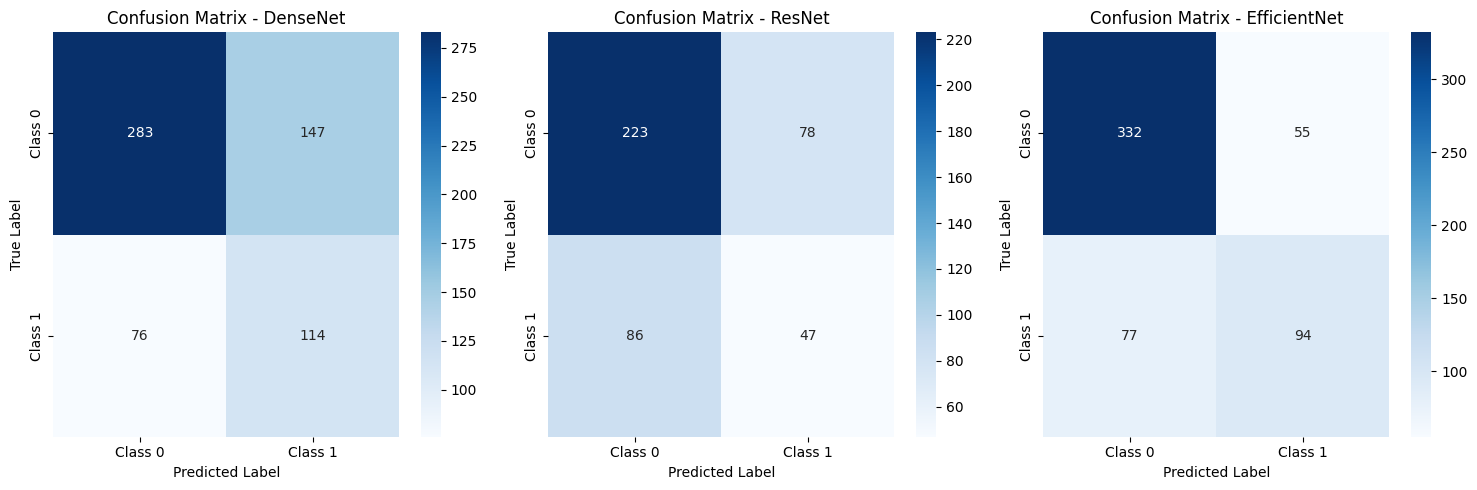

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrices data
confusion_matrices = [
    np.array([[283, 147], [76, 114]]),  # DenseNet
    np.array([[223, 78], [86, 47]]),    # ResNet
    np.array([[332, 55], [77, 94]])     # EfficientNet
]

# Class labels
class_labels = ['Class 0', 'Class 1']

# Plotting confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (confusion_matrix, model_name) in enumerate(zip(confusion_matrices, ['DenseNet', 'ResNet', 'EfficientNet'])):
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {model_name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()


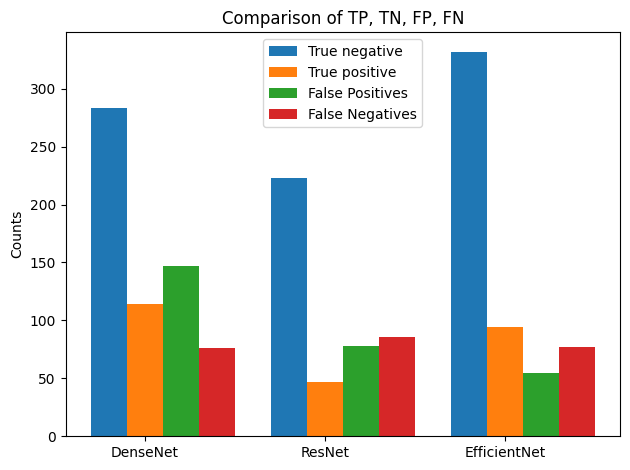

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrices data
confusion_matrices = [
    np.array([[283, 147], [76, 114]]),  # DenseNet
    np.array([[223, 78], [86, 47]]),    # ResNet
    np.array([[332, 55], [77, 94]])     # EfficientNet
]

# Extract TP, TN, FP, FN
tps = [cm[0, 0] for cm in confusion_matrices]
tns = [cm[1, 1] for cm in confusion_matrices]
fps = [cm[0, 1] for cm in confusion_matrices]
fns = [cm[1, 0] for cm in confusion_matrices]

# Class labels
model_names = ['DenseNet', 'ResNet', 'EfficientNet']

# Plotting
x = np.arange(len(model_names))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, tps, width, label='True negative')
rects2 = ax.bar(x, tns, width, label='True positive')
rects3 = ax.bar(x + width, fps, width, label='False Positives')
rects4 = ax.bar(x + 2*width, fns, width, label='False Negatives')

ax.set_ylabel('Counts')
ax.set_title('Comparison of TP, TN, FP, FN')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

fig.tight_layout()

plt.show()


# Precision Comparison

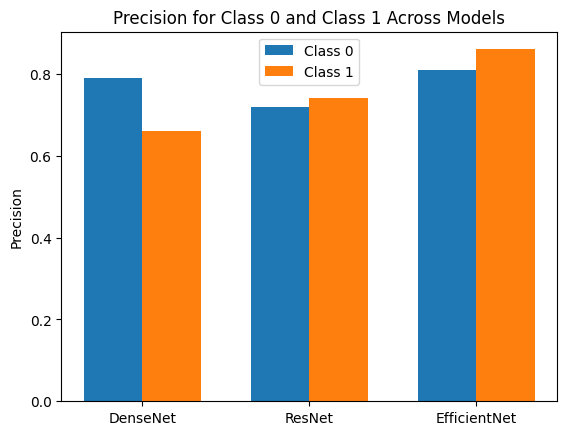

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Classification report data
# Precision for class 0 and class 1
# Each row represents a model
precision_class_0 = [0.79, 0.72, 0.81]  # Precision for class 0 for DenseNet, ResNet, and EfficientNet
precision_class_1 = [0.66, 0.74, 0.86]  # Precision for class 1 for DenseNet, ResNet, and EfficientNet

# Model names
model_names = ['DenseNet', 'ResNet', 'EfficientNet']

# Plotting
x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, precision_class_0, width, label='Class 0')
rects2 = ax.bar(x + width/2, precision_class_1, width, label='Class 1')

# Add labels, title, and legend
ax.set_ylabel('Precision')
ax.set_title('Precision for Class 0 and Class 1 Across Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Show plot
plt.show()


# F1 Comparison

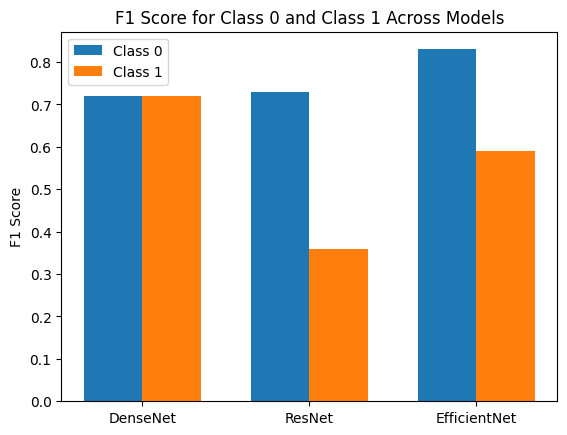

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Classification report data
# F1-score for class 0 and class 1
# Each row represents a model
f1_score_class_0 = [0.72, 0.73, 0.83]  # F1-score for class 0 for DenseNet, ResNet, and EfficientNet
f1_score_class_1 = [0.72, 0.36, 0.59]  # F1-score for class 1 for DenseNet, ResNet, and EfficientNet

# Model names
model_names = ['DenseNet', 'ResNet', 'EfficientNet']

# Plotting
x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, f1_score_class_0, width, label='Class 0')
rects2 = ax.bar(x + width/2, f1_score_class_1, width, label='Class 1')

# Add labels, title, and legend
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score for Class 0 and Class 1 Across Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Show plot
plt.show()


# Recall Comparison

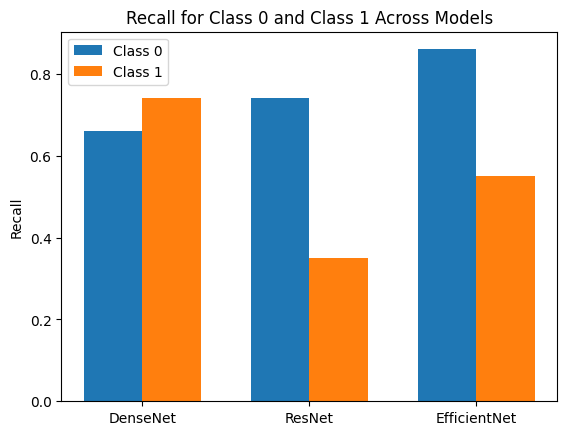

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Recall data for class 0 and class 1
recall_class_0 = [0.66, 0.74, 0.86]  # Recall for class 0 for DenseNet, ResNet, and EfficientNet
recall_class_1 = [0.74, 0.35, 0.55]  # Recall for class 1 for DenseNet, ResNet, and EfficientNet

# Model names
model_names = ['DenseNet', 'ResNet', 'EfficientNet']

# Plotting
x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, recall_class_0, width, label='Class 0')
rects2 = ax.bar(x + width/2, recall_class_1, width, label='Class 1')

# Add labels, title, and legend
ax.set_ylabel('Recall')
ax.set_title('Recall for Class 0 and Class 1 Across Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Show plot
plt.show()


# Accurcay Comparison

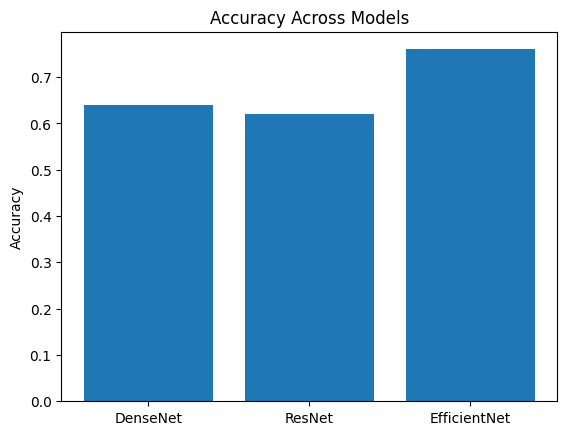

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data for all models
accuracy_data = [0.64, 0.62, 0.76]  # Accuracy for DenseNet, ResNet, and EfficientNet

# Model names
model_names = ['DenseNet', 'ResNet', 'EfficientNet']

# Plotting
x = np.arange(len(model_names))  # the label locations

fig, ax = plt.subplots()
rects = ax.bar(x, accuracy_data)

# Add labels, title, and legend
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Across Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)

# Show plot
plt.show()
